## Part 4 Fitting simple (2-parameter) systematics model

* Cloned from tutorial_part4_fitting_systematics_model

In [1]:
#check python version
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## import data

In [4]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'hatp44_QL*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./hatp44_QL_g-band.csv', './hatp44_QL_r-band.csv', './hatp44_QL_z-band.csv']

In [5]:
data={}

bands = 'g,r,z'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_csv(fname, delimiter=',', parse_dates=True)
    df = df.drop('Unnamed: 0',axis=1)
    df = df.set_index('BJD(TDB)-2450000')
    data[b] = df
    
data.keys()

dict_keys(['g', 'r', 'z'])

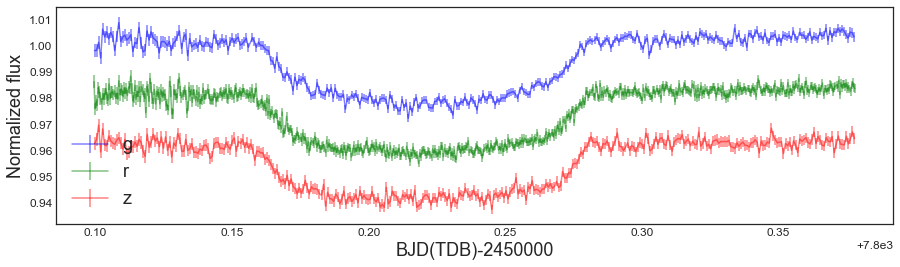

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

## setting-up the transit model 

```
* t:     time
* k:     Rp/Rs: planet-star radius ratio (=k^2: transit depth)
* u1,u2: limb-darkening coefficients
* tc:    transit center
* P:     orbital period
* a_s:   a/Rs: scaled semi-major axis
* i:     inclination
* e:     eccentricity
* w:     argument of periastron
* c:     contamination factor
```

See transit parameters for HAT-P-44b at [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [7]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [8]:
from astropy import units as u

_tc  = 2455696.93695
_P   = 4.301219
_inc = np.deg2rad(89.10)
_t14  = 0.13020
_b    = 0.172

Rp = 1.24 #Rjup
Rs = 0.949*u.Rsun.to(u.Rjup) #Rsol to Rjup
k_ = Rp/Rs

_a_s = 11.52
a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)

tc_0      = 7.8e3+0.22 #-2450000

In [9]:
import limbdark as ld

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

ldc_list     = []
ldc_err_list = []

#for each band
for i in 'g*,r*,z*'.split(','):
    ldc = ld.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    
    #save in list
    #u1,u2
    ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
    #uncertainties
    ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Optimizing transit parameters: Frequentist approach

### 1. Maximum Likelihood Estimation (MLE)

See part3; See part5 for Bayesian approach

In [10]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((m-f)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    #return np.sqrt((residual**2).sum()/residual.size)
    
    #(flux/sys_model - transit_model) / error,
    #or (flux - transit_model*sys_model) / error
    return np.sqrt(np.mean((residual)**2))

g-band
rms before: 0.0032
rms after: 0.0026

r-band
rms before: 0.0032
rms after: 0.0026

z-band
rms before: 0.0036
rms after: 0.0028



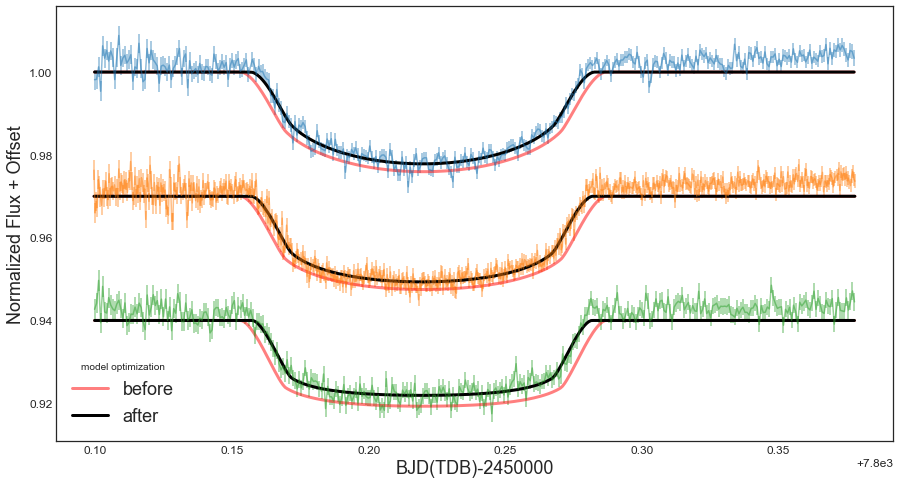

In [11]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot raw data with vertical offset
    offset = n*0.03
    pl.errorbar(time, flux-offset, yerr=err, alpha=0.5) 
    
    #compute q from u found in limbdark
    q1_,q2_ = u_to_q(u[0],u[1])

    #compute flux before optimization
    transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b]
    transit_model_before  = transit_model_q(transit_params, _P, time)
    #rms before
    rms_before = rms(flux,transit_model_before)
    print('rms before: {:.4f}'.format(rms_before))
    
    #optimize parameters
    result = op.minimize(obj, transit_params,
                         args=(_P, time, flux, err), method='nelder-mead')
    
    #compute flux after optimization
    transit_params_after = np.copy(result.x)
    transit_model_after  = transit_model_q(transit_params_after, _P, time)
    #rms after
    rms_after = rms(flux,transit_model_after)
    print('rms after: {:.4f}\n'.format(rms_after))
    
    #plot transit models
    #before (faint red)
    ax.plot(time, transit_model_before-offset, 'r-', lw=3, alpha=0.5)
    #after (black)
    ax.plot(time, transit_model_after-offset, 'k-', lw=3, alpha=1)
    ax.legend(fontsize=fontsize)
    
    #dict of optimized transit parameters to be used later
    optimized_transit_params[b] = transit_params_after
    n+=1
    
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
ax.set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [12]:
optimized_transit_params

{'g': array([  1.28330953e-01,   6.94722181e-01,   4.65491536e-01,
          7.80021976e+03,   1.21625800e+01,   1.72028975e-01]),
 'r': array([  1.28408329e-01,   5.53907376e-01,   3.49739851e-01,
          7.80021952e+03,   1.22467056e+01,   1.72044914e-01]),
 'z': array([  1.25171086e-01,   3.43090243e-01,   2.07678538e-01,
          7.80021956e+03,   1.22930550e+01,   1.71164788e-01])}

## Optimizing transit parameters: Bayesian approach

See part6.

---

## Modeling systematics

Transit light curve contains various information. Aside from the transit signal, it also (generally) contains systematic noise and photometric noise.

![img](images/modeling.png)

Systematics is a catch-all term that accounts for the noise in the light curve except photometric noise. Systematics is largely composed of (but not limited to):

* stellar variability
* instrumental noise (detector, tracking problems, etc.)
* atmospheric variability
* etc.

What we would like to do is to model all of them together and at the same time (i.e simultaneous) to get the best fit parameters; not model them separately by removing systematic first and then fitting for transit parameters (or vice-versa). We will show how to do simultaneous modeling in the mcmc part (part6) of this tutorial series. 

Let's try to understand first how to model the systematics separately from the transit signal. It must be emphasized rightaway that modeling transit and systematics separately is usually wrong because we do not have complete complete understanding of either the transit or systematics component of the light curve.

For now, let's assume that the transit parameters we obtained after optimization are correct. We will remove the transit signal from the light curve so that the residual signal is assumed to contain the systematics only.

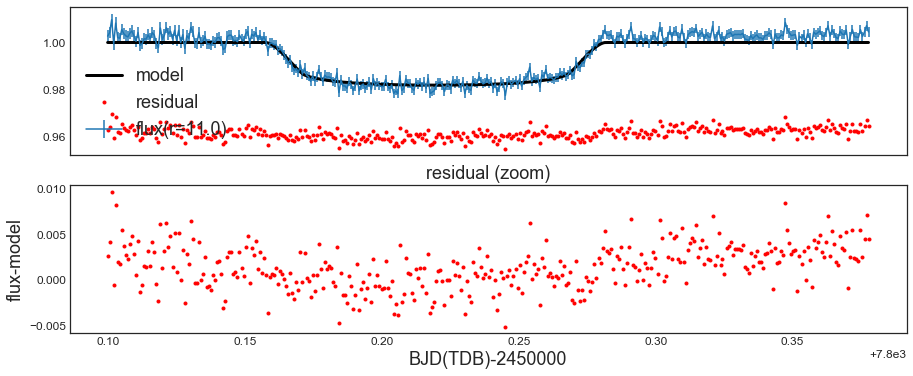

In [13]:
fluxcol='flux(r=11.0)'
errcol ='err(r=11.0)'

#choose any band
b    = 'z'
df   = data[b]
time = df.index
flux = df[fluxcol]
err  = df[errcol]

#flux model with optimized transit parameters
transit_model = transit_model_q(optimized_transit_params[b], _P, time)

fig,ax = pl.subplots(2,1,figsize=(15,6), sharex=True)

ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')


#plot residual
offset= 0.96
resid = flux-transit_model
ax[0].plot(time, resid+offset, 'r.', label='residual', lw=2)
ax[0].legend(fontsize=fontsize)

#plot residual again, but in a new axis
ax[1].plot(time, resid, 'r.', lw=2)
rms(flux,transit_model)
ax[1].set_title('residual (zoom)',fontsize=fontsize)
ax[1].set_ylabel('flux-model',fontsize=fontsize)
ax[1].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)

## Systematics model

* See Research Note by Luger et al. ([2017](https://arxiv.org/pdf/1710.11136.pdf))

As in [Fukui et al. (2016a)](https://arxiv.org/pdf/1510.03997.pdf), the transit and out-of-transit (transit+OOT) model is expressed as
$$
F_{rel}=S\times F_{model}
$$
where $F_{rel}$ is the relative flux (raw flux of target star divided by flux of comparison star obtained from relative photometry), $F_{model}$ is the transit light curve model, and $S$ is the systematics. Thus, systematics is the normalization function of the light curve (derived from differential photometry):
$$
S = \frac{F_{rel}}{F_{model}}
$$

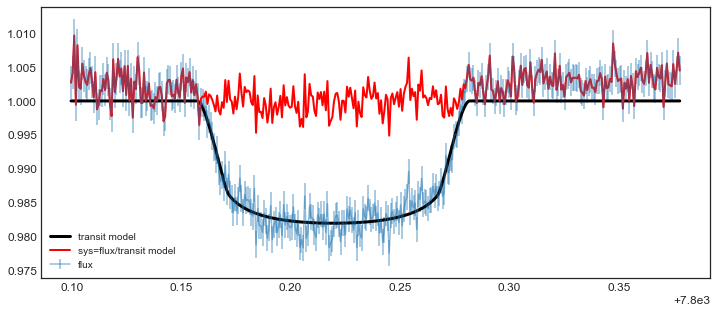

In [14]:
fig = pl.figure(figsize=(12,5))

pl.errorbar(time, flux, yerr=err,alpha=0.5,label='flux')
pl.plot(time, transit_model, 'k-', lw=3, label='transit model')

#systematics
sys = flux/transit_model
pl.plot(time, sys, 'r-', lw=2, label='sys=flux/transit model')
pl.legend()

We can model the systematics (red line above) in two general ways:
* [parametric](https://en.wikipedia.org/wiki/Parametric_model)
* [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics)

A parametric model basically means the model has given finite set of parameters. A common example of a parametric systematics model is a linear combination of constant coefficients and auxiliary observables (e.g., [Fukui et al. (2016a)](https://arxiv.org/pdf/1510.03997.pdf)):
$$
S_i = w_0+w_1X_1+ \ldots + w_nX_n \\
S_i=w_0+\sum w_iX_i
$$
where $S_i$ is the function we want to model (i.e. flux normalized by the transit model), $X_i$ is the set of observables (e.g. centroid position of target, airmass, etc.), and $w_i$ is the set of coefficients (or weights) of $X_i$.

Using Maximum Likelihood Estimation (MLE) to compute/optimize $w$ is not recommended (and will most likely fail) because we don't have good guesses for the initial values of the constant coefficients. Remember in our transit modeling, we have good guesses for limb-dakening coefficients, transit center, etc.

A non-parametric model basically means the model has infinite parameters and usually has no auxiliary parameters needed to model the data. An example of a non-parametric model used frequently to model transit light curves is the [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) model which we will not disccuss in this tutorial (let's ask John!). ~~For simplicity, a simpler non-parametric model using Radial Basis Function is shown (in the Appendix) to compare with the result of the parameteric modeling.~~

| Parametric Model        | Non-parameteric Model  |
|:-----------------------:|:----------------------:|
| physical model          | mathematical model                     |
| easy & (usually) fast   | requires expertise & (usually) slow    |

---

### least-square/ $\chi^2$-square (Linear algebra)

Let's implement ordinary least square/ chi-square using linear algebra. 

Now our task is to do [multiple regression](https://en.wikipedia.org/wiki/Design_matrix#Multiple_regression). 
Our aim is to compute the weights $w$ (or coefficients of the systematics model):
$$
y_i=w_0+\sum_{i=0}w_iX_i
$$
given two or more variables in $X$. 

In vector form,
$$
y= X \cdot w
$$

Solving for $w$,
$$
X^T \cdot y = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot y = w
$$
where $y$ is the function we want to model (e.g. flux / transit model) and $X$ is the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)" that contains auxiliary the observables.

$X$ can be composed of any auxiliary observables such as
```

* target centroid           e.g. dx(pix), dy(pix)
* airmass
* sky background            e.g. sky(ADU)
* fwhm                      e.g. fwhm(pix)
* peak flux                 e.g. peak(ADU)
* error or flux uncertainty e.g. err(r=11.0)
* color                     e.g. flux_g/flux_r

* CCD temperature
* etc.

* powers of [param]         e.g. dx^2, dy^2
* cross-term                e.g. dx*dy
* etc.

In K2 (post-Kepler) time-series data, an additional observable used is spacecraft motion
```

We can use the `numpy` functions below to solve the equation above. 
* `np.dot ` for dot product
* `np.linalg.inv ` for inverse
* `[vector].T ` for transpose

However, we will use `np.linalg.solve` (instead of `np.linalg.inv`) to avoid problems related with matrices that cannot be inverted. See details in [StackOverflow](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li).

Let's construct $X$ for the z-band for now.

In [15]:
b='z'
df = data[b]

df.columns

Index(['airmass', 'sky(ADU)', 'dx(pix)', 'dy(pix)', 'fwhm(pix)', 'peak(ADU)',
       'flux(r=9.0)', 'err(r=9.0)', 'flux(r=10.0)', 'err(r=10.0)',
       'flux(r=11.0)', 'err(r=11.0)', 'flux(r=12.0)', 'err(r=12.0)',
       'flux(r=13.0)', 'err(r=13.0)', 'flux(r=14.0)', 'err(r=14.0)'],
      dtype='object')

In [16]:
dx        = df['dx(pix)']
dy        = df['dy(pix)']
airmass   = df['airmass']
sky       = df['sky(ADU)']
fwhm      = df['fwhm(pix)']
peak      = df['peak(ADU)']
err       = df['err(r=11.0)']

flux      = df['flux(r=11.0)']

### Simple systematics model

First, let's model the systematics using the flux itself. We can also add the vertical offset $w_0$, by adding a vector of 1: e.g. [1,1,1,1,...,1] using `np.ones_like(x)`. Then we can concatenate the two vectors using `np.c_`

In [17]:
X = np.c_[np.ones_like(flux), flux]
#show the first 5 values of dx and dy
X[:5]

array([[ 1.      ,  1.002697],
       [ 1.      ,  1.004157],
       [ 1.      ,  1.009671],
       [ 1.      ,  0.99945 ],
       [ 1.      ,  1.008227]])

Then, compute weights (coefficients) $w$ of systematic model using the residual.

In [18]:
#resid  = flux-transit_model
sys    = flux/transit_model

w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
w

array([ 0.83064386,  0.17170327])

Thus, the systematics model is simply:

In [19]:
sys_model = np.dot(X,w)

The transit depth is about ~0.02. We can set our tolerance level for the difference between the model and the data at least one order of magnitude smaller than the transit depth: ~0.002.

In [20]:
#check precision
np.allclose(sys, sys_model, rtol=2e-3)

False

Note that the number of coefficients $w$ should be equal to the number of observables (or columns) in $X$. We used `dx` and `dy` so we have two coefficients.

The plot below shows:
1. flux and best-fit transit model
2. systematics and the computed systematic model
3. corrected lightcurve: `flux/sys_model-transit_model`

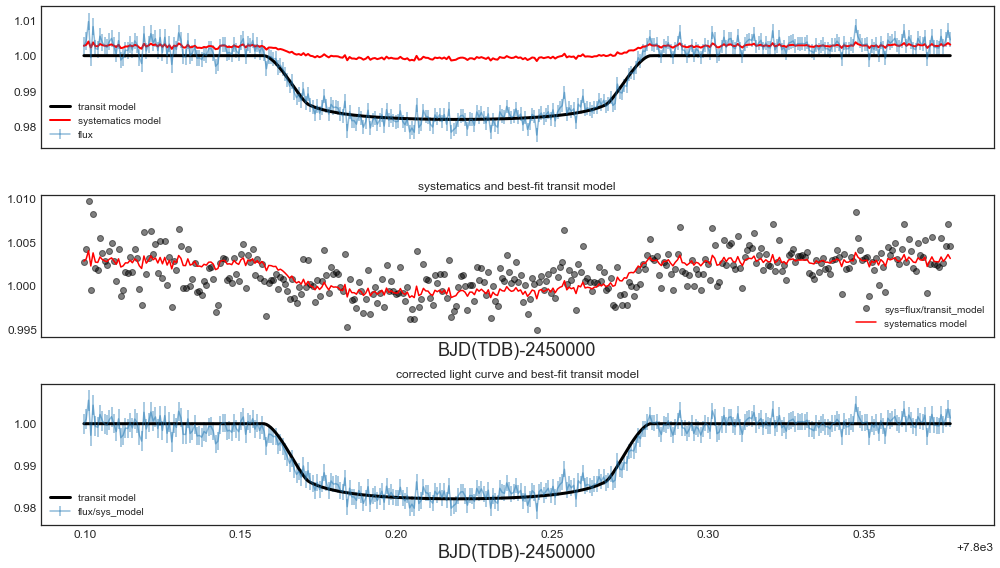

In [21]:
fig, ax   = pl.subplots(3,1,figsize=(14,8), sharex=True)

#ax[0].plot(time, flux, 'bo', alpha=0.5, label='raw data')
ax[0].errorbar(time, flux, yerr=err, alpha=0.5, label='flux')
ax[0].plot(time, transit_model, 'k-', lw=3, label='transit model')
ax[0].plot(time, sys_model, 'r-', lw=2, label='systematics model')
ax[0].legend()

ax[1].plot(time, sys, 'ko', alpha=0.5, label='sys=flux/transit_model')
ax[1].plot(time, sys_model, 'r-', label='systematics model')
ax[1].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax[1].set_title('systematics and best-fit transit model')
ax[1].legend()


ax[2].errorbar(time, flux/sys_model, yerr=err, alpha=0.5, label='flux/sys_model')
ax[2].plot(time, transit_model, 'k-', lw=3, label='transit model')
ax[2].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax[2].set_title('corrected light curve and best-fit transit model')
ax[2].legend()

fig.tight_layout()

The computed systematics model (red line) above fits the out of transit light curve quite well.

In [22]:
#compute rms
rms1 = rms(flux, transit_model)
rms2 = rms(flux/sys_model, transit_model)
print('rms of residual:\n{:.4f}'.format(rms1))
print('rms of residual w/o systematics:\n{:.4f}'.format(rms2))

rms of residual:
0.0028
rms of residual w/o systematics:
0.0017


In [23]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return np.array(a_b)

def binned_rms(residuals, timestep, start_min=5, stop_min=20):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    """

    assert timestep < start_min * 60
    ndata = len(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    rms_err      = []
    rms_err_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
                
        #binning       
        rms_val = np.sqrt(np.mean(binned(residuals,bs)**2))
        rms_err.append(rms_val)
        rms_err_dict[bs] = rms_val
        
    return rms_err_dict

In [24]:
rms_binned = {}

exptimes = [60,30,60] #sec

for b,ts in zip(bands,exptimes):
    df=data[b]
    
    ndata = len(df)
    nparams = 2
    
    time  = df.index
    flux  = df[fluxcol].values
    err   = df[errcol].values
    
    transit_model = transit_model_q(optimized_transit_params[b], _P, time)
    sys    = flux/transit_model
    X = np.c_[flux, np.ones_like(flux)]
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
    sys_model = np.dot(X,w)
    
    data[b]['transit_model'] = transit_model 
    data[b]['sys_model'] = sys_model
    
    resid = flux/sys_model - transit_model
    data[b]['residual'] = resid
    
    #resid = df['residual'].values
    rms_bin = binned_rms(resid, ts, start_min=5, stop_min=40)
    rms_binned[b] = rms_bin

(0, 40)

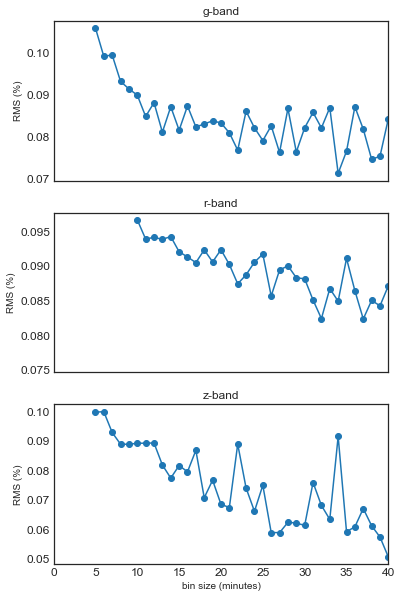

In [25]:
fig,ax=pl.subplots(3,1,figsize=(6,10), sharex=True)
b='g'
n=0
for b in bands:
    ax[n].plot(list(rms_binned[b].keys()),
               np.array(list(rms_binned[b].values()))*100, 'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_ylabel('RMS (%)')
    #ax[n].set_ylim(-0.001,0.001)
    n+=1
ax[n-1].set_xlabel('bin size (minutes)')
ax[n-1].set_xlim(0,40)

## Reduced $\chi^2$

In [26]:
def chisq(resid, err, ndata=None, nparams=None, reduced=False):
    '''
    resid: residual = flux/sys_model - transit_model
    err  : error in flux
    '''
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return sum((resid / err)**2) / (dof)
    else:
        return sum((resid / err)**2)

In [27]:
reduced_chi2 = {}

newerrcols = []

for b in bands:
    df = data[b]
    ndata = len(df)
    nparams = 2
    
    time  = df.index
    flux  = df[fluxcol]
    err   = df[errcol]
        
    resid = data[b]['residual']
    
    #resid = df['resid']
    chi2 = chisq(resid, err, reduced=False)
    red_chi2 = chisq(resid, err, ndata, nparams, reduced=True)
    
    #save
    reduced_chi2[b] = red_chi2
    col='err(r=11.0)*{:.2f}'.format(red_chi2)
    newerrcols.append(col)
    
    #inflate error
    if red_chi2>1:
        df[col] = err*red_chi2
    #be conservative and preserve orig err
    else: 
        df[col] = err
    
    #print(len(err*factor))
    print('chi2 ={:.4f}'.format(chi2))
    print('reduced chi2 ={:.4f}'.format(red_chi2))

chi2 =397.0913
reduced chi2 =1.0646
chi2 =760.6287
reduced chi2 =1.0835
chi2 =273.3496
reduced chi2 =0.7309


In [28]:
reduced_chi2

{'g': 1.06458782206387, 'r': 1.0835165962464715, 'z': 0.73088123909314506}

## beta factor

In [29]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

In [30]:
beta_factor_list = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20, return_dict=True)
    beta_factor_list[b]= beta_fac

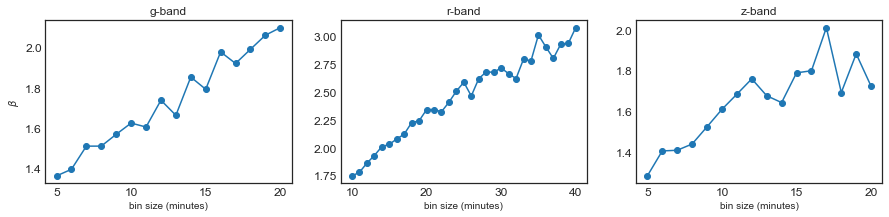

In [31]:
fig,ax=pl.subplots(1,3,figsize=(15,3))
b='g'
n=0
for b in bands:
    ax[n].plot(list(beta_factor_list[b].keys()),list(beta_factor_list[b].values()),'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_xlabel('bin size (minutes)')
    n+=1
ax[0].set_ylabel(r'$\beta$')

In [36]:
beta_factor = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20)
    beta_factor[b]= beta_fac
    
    err = df[col]
    
    #inflate error once more (after rescaling red. chi-squared)
    inflated_err = err * beta_fac
    
    #add to df 
    data[b]['err_inflated'] = inflated_err
    
    print('beta factor ={:.4f}'.format(beta_fac))

beta factor =1.7011
beta factor =2.5077
beta factor =1.6793


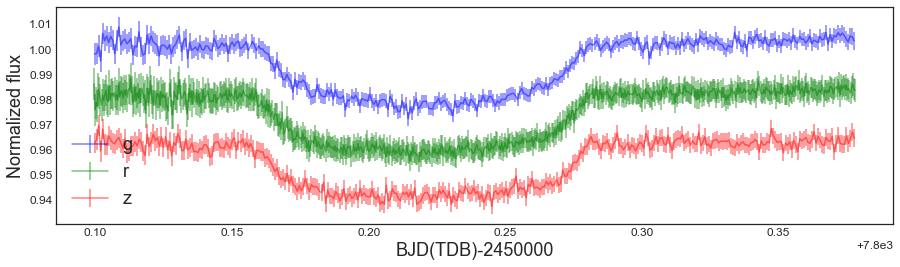

In [37]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err_inflated' #'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

fig.savefig('inflated_err.png')

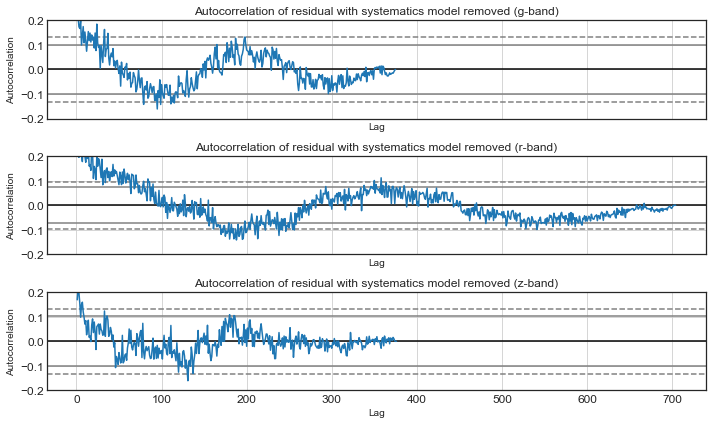

In [38]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    flux = df[fluxcol]
    
    #get models computed earlier    
    transit_model = data[b]['transit_model']
    sys_model = data[b]['sys_model']
    
    resid_wo_sys = flux / sys_model - transit_model
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()

The autocorrelation of each band suggests that the residual with systematics removed cannot not be purely white noise because of the large amplitudes exceeding the dashed lines (~3 sigma).

---

In [37]:
errs=[]
for b in bands:
    df=data[b]
    errs.append(df['err_inflated'])  